In [ ]:
"""
2018년도 1학기 투자론 기말과제
<Aiyagari Model dictation>
2018110045 경영학과 이인호
"""

In [1]:
import numpy as np
from numba import jit

class Household:
    """
    This class takes the parameters that define a household asset accumulation
    problem and computes the corresponding reward and transition matrices R
    and Q required to generate an instance of DiscreteDP, and thereby solve
    for the optimal policy.

    Comments on indexing: We need to enumerate the state space S as a sequence
    S = {0, ..., n}.  To this end, (a_i, z_i) index pairs are mapped to s_i
    indices according to the rule

        s_i = a_i * z_size + z_i 

    To invert this map, use
    
        a_i = s_i // z_size  (integer division)
        z_i = s_i % z_size

    """


    def __init__(self,
                 r=0.01,                      # 이자율
                 w=1.0,                       # 임금
                 β=0.96,                      # discount factor
                 a_min=1e-10, #아주 작은 자산 a_min부터 시작함.
                 Π=[[0.7, 0.3], [0.3, 0.7]],  # 마코브 체인
                 #상태를 유지하려는 확율이 매우 높게 셋팅 되어 있음.
                 
                 z_vals=[0.1, 1.0],           # 외생상태, 환경 등을 의미
                 # 0.1은 고용이 매우 낮은 확율의 상태,
                 #1.0은 고용이 확실한 상태. z에서는 2가지의 상태를 가정
                 
                 a_max=18, #자산의 최대값 설정
                 a_size=200):

        # Store values, set up grids over a and z
        self.r, self.w, self.β = r, w, β
        self.a_min, self.a_max, self.a_size = a_min, a_max, a_size

        self.Π = np.asarray(Π)
        self.z_vals = np.asarray(z_vals)
        self.z_size = len(z_vals)

        self.a_vals = np.linspace(a_min, a_max, a_size)
        # 200개의 점을 min과 max 사이에서 만들어줌.
        self.n = a_size * self.z_size
        #a와 z를 곱해서 n을 만들어 주는데,
        #이는 자산의 상태와 고용의 상태를 조합한
        #모든 경우의 수를 n으로 셋팅해 주는 것임

        # Build the array Q
        self.Q = np.zeros((self.n, a_size, self.n))
        self.build_Q()
        # 0행렬을 만들어 줌

        # Build the array R
        self.R = np.empty((self.n, a_size))
        self.build_R()
        #모든 자산에 대한 경우의 수를 R 행렬로 셋팅

    def set_prices(self, r, w):
        """
        자산을 재설정하기 위한 함수임
        """
        self.r, self.w = r, w
        self.build_R()

    def build_Q(self):
        populate_Q(self.Q, self.a_size, self.z_size, self.Π)

    def build_R(self):
        self.R.fill(-np.inf) #먼저 -inf 값을 채워 넣음
        #나중에 계산 하면서 feasible value는 -inf에서 바꿔서 채움
        populate_R(self.R, self.a_size, self.z_size, self.a_vals, self.z_vals, self.r, self.w)


# Do the hard work using JIT-ed functions

@jit(nopython=True)
def populate_R(R, a_size, z_size, a_vals, z_vals, r, w):
    n = a_size * z_size
    for s_i in range(n): #400까지 for loop 돌리기
        a_i = s_i // z_size #몫만 가져옴
        # [0, 1, 1, 2, 2, 3, 3, 4, ... , 199, 200] -> 400개
        z_i = s_i % z_size #나머지만 가져옴
        # [1, 0, 1, 0, 1, 0, ..., 1, 0] -> 400개
        # class 가장 위에 써있던 것과 마찬가지로
        # s_i = a_i * z_size + z_i 를 의미하는 식임.
        a = a_vals[a_i]
        z = z_vals[z_i] #고용의 확률 2가지 경우인 0.1과 1을 번갈아서...
        for new_a_i in range(a_size): # 200까지 for loop 돌리기
            a_new = a_vals[new_a_i] #asset의 points를 200개까지 나눈 것을
            #a_new로 순서대로 받아줌.
            c = w * z + (1 + r) * a - a_new
            #a모든 경우의수를 다 받아서 c를 만들어줌
            if c > 0:
                R[s_i, new_a_i] = np.log(c)  # Utility
                #c가 0보다 큰 경우에만 R에 넣어줌...

@jit(nopython=True)
def populate_Q(Q, a_size, z_size, Π):
    n = a_size * z_size #n은 400이 되고...
    for s_i in range(n): #400까지 루프
        z_i = s_i % z_size
        #위에서와 마찬가지로 1,0이 반복되는 z_i가 나옴.
        for a_i in range(a_size): #200까지 루프
            for next_z_i in range(z_size): #2개 루프
                Q[s_i, a_i, a_i * z_size + next_z_i] = Π[z_i, next_z_i]
                #마코브 체인을 활용해서 Q 값을 만들어줌.


@jit(nopython=True)
def asset_marginal(s_probs, a_size, z_size):
    a_probs = np.zeros(a_size) #200개 0행렬 만들어줌.
    for a_i in range(a_size): #루프 200번까지 돌려주고
        for z_i in range(z_size): #동시에 2개 루프를 함께 돌려서
            #z의 상태 2가지를 계속 반복해줌.
            a_probs[a_i] += s_probs[a_i * z_size + z_i]
            #s_probs 안에 있는 수식이 s_i임.
            # s_probs는 staitionary probability를 의미함.
    return a_probs

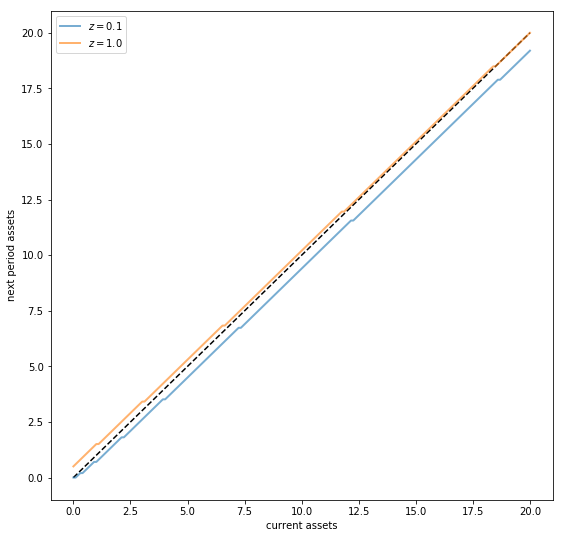

In [3]:
import quantecon as qe
import matplotlib.pyplot as plt
from quantecon.markov import DiscreteDP

# Example prices
r = 0.03
w = 0.956

# Create an instance of Household
am = Household(a_max=20, r=r, w=w)

# Use the instance to build a discrete dynamic program
am_ddp = DiscreteDP(am.R, am.Q, am.β)

# Solve using policy function iteration
results = am_ddp.solve(method='policy_iteration')

# Simplify names
z_size, a_size = am.z_size, am.a_size
z_vals, a_vals = am.z_vals, am.a_vals
n = a_size * z_size

# Get all optimal actions across the set of a indices with z fixed in each row
a_star = np.empty((z_size, a_size))
for s_i in range(n):
    a_i = s_i // z_size
    z_i = s_i % z_size
    a_star[z_i, a_i] = a_vals[results.sigma[s_i]]

fig, ax = plt.subplots(figsize=(9, 9))
ax.plot(a_vals, a_vals, 'k--')  # 45 degrees
for i in range(z_size):
    lb = f'$z = {z_vals[i]:.2}$'
    ax.plot(a_vals, a_star[i, :], lw=2, alpha=0.6, label=lb)
    ax.set_xlabel('current assets')
    ax.set_ylabel('next period assets')
ax.legend(loc='upper left')

plt.show()
"""
그래프의 의미는,
z=0.1이나 z=1.0이나 현재 자산과 다음분기의 자산 변화가 크지 않다는 것임.
자산이 많은 경우에도 다음 분기의 자산은 많을 것이고
자산이 적은 경우에도 다음 분기의 자산은 적을 것이라는 의미임.
이는 y=x (45도 라인)와 z의 두 개의 선이 가깝기 때문임.
또한 두 개의 z라인이 가깝게 있다는 것 역시
현재 자산과 다음 분기의 자산의 변화가 두 z간 큰 차이가 없다는 것을 의미함.
즉, 자산은 고용의 상태인 z에 의존하는 것이 아님.
"""

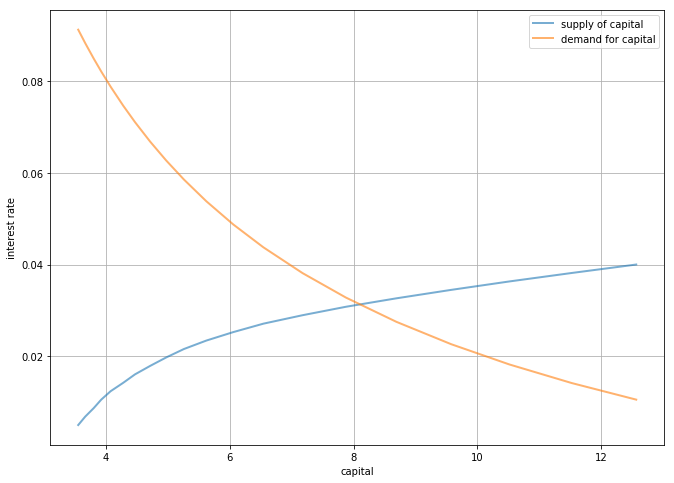

In [18]:
A = 1.0
N = 1.0
α = 0.33
β = 0.96
δ = 0.05


def r_to_w(r): #이자율 r에 따른 균형자산의 수식을 정의해줌.
    # r에 따른 값을 보기 위해서 함수로 수식을 정의함.
    """
    Equilibrium wages associated with a given interest rate r.
    """
    return A * (1 - α) * (A * α / (r + δ))**(α / (1 - α))

def rd(K): #자본(K)의 수식을 정의해줌.
    # K에 따른 값을 보기 위해서 함수로 수식을 정의함.
    """
    Inverse demand curve for capital.  The interest rate associated with a
    given demand for capital K.
    """
    return A * α * (N / K)**(1 - α) - δ


def prices_to_capital_stock(am, r):
    """
    Map prices to the induced level of capital stock.
    
    Parameters:
    ----------
    
    am : Household
        An instance of an aiyagari_household.Household 
    r : float
        The interest rate
    """
    w = r_to_w(r) #위에서 정의한 수식(함수)를 사용해줌
    am.set_prices(r, w) #자산 재설정
    aiyagari_ddp = DiscreteDP(am.R, am.Q, β)#Aiyagari 모델 설정.
    # Compute the optimal policy
    results = aiyagari_ddp.solve(method='policy_iteration')
    # Compute the stationary distribution
    stationary_probs = results.mc.stationary_distributions[0]
    # Extract the marginal distribution for assets
    asset_probs = asset_marginal(stationary_probs, am.a_size, am.z_size)
    # Return K
    return np.sum(asset_probs * am.a_vals)


# Create an instance of Household
am = Household(a_max=20)

# Use the instance to build a discrete dynamic program
am_ddp = DiscreteDP(am.R, am.Q, am.β)

# Create a grid of r values at which to compute demand and supply of capital
num_points = 20
r_vals = np.linspace(0.005, 0.04, num_points)

# Compute supply of capital
k_vals = np.empty(num_points)
for i, r in enumerate(r_vals):
    k_vals[i] = prices_to_capital_stock(am, r)

# Plot against demand for capital by firms
fig, ax = plt.subplots(figsize=(11, 8))
ax.plot(k_vals, r_vals, lw=2, alpha=0.6, label='supply of capital')
ax.plot(k_vals, rd(k_vals), lw=2, alpha=0.6, label='demand for capital')
ax.grid()
ax.set_xlabel('capital')
ax.set_ylabel('interest rate')
ax.legend(loc='upper right')

plt.show()
"""
자본(K)과 이자율(r)의 관계를 나타낸 그래프임.
자본의 공급과 수요에 따라 균형 이자율을 나타냄.
이자율을 기준으로 해석하면,
1. 금리가 낮다면
- 기업 입장에서는 대출에 대한 수요가 높고(자본을 많이 필요로함)
- 가계 입장에서는 저축이 낮음(기업에게 공급(supply)이 낮음)
2. 반대로, 금리가 높다면
- 기업 입장에서는 대출 부담이 커서 수요가 낮고
- 가계 입장에서는 저축을 늘려감. 그러나 기본적인 소비(c)가 있기 때문에 무한대로 저축을 늘릴 수는 없다.
==> 이러한 조건 때문에 균형 가격이 생성됨.
"""